# Churn prediction

### Author: Rasmus Davidsen
### Copenhagen, 02-12-2022


### Steps 
1) import and preprocess data 

2) profile data 

4) split data 

3) define and train pipeline


5) 


In [18]:
# for dataframes. options is set so the entire table can be inspected
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]

# for convenient plotting
import seaborn as sns

# for a very detailed data profile
from pandas_profiling import ProfileReport
import ipywidgets

# cool library for data quality checks
#import great_expectations as ge



import numpy as np
from sklearn import set_config
set_config(display='diagram')

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

## Import data and inspect

In [2]:
# import semicolon separated .csv file and inspect the shape
df = pd.read_csv('data/case_data_set.csv', delimiter=";")
df.shape

(5374, 21)

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,"29,85","29,85",No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,"56,95","1889,5",No
2,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),"42,3","1840,75",No
3,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),"89,1","1949,4",No
4,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,"29,75","301,9",No


In [4]:
df.dtypes

customerID          object
gender              object
SeniorCitizen        int64
Partner             object
Dependents          object
tenure               int64
PhoneService        object
MultipleLines       object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
Contract            object
PaperlessBilling    object
PaymentMethod       object
MonthlyCharges      object
TotalCharges        object
Churn               object
dtype: object

## Change data types
As the "TotalCharges" and the "MonthlyCharges" columns are given with the danish "," decimal separater this must be changed. Furtermore, we need to change the data type from object to float.

In [5]:
# replace , by . and change to float data type
df['TotalCharges'] = df['TotalCharges'].str.replace(',','.').astype(float)
df['MonthlyCharges'] = df['MonthlyCharges'].str.replace(',','.').astype(float)

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
3,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
4,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No


## Data set profiling 
In order to inspect the columns for missings, the distributions etc. pandas_profiling package is used to generate a detailed report containing a profile of the data

In [7]:
#profile = ProfileReport(df, title ="churn data profile", html={'style':{'full_width':True}})

In [8]:
#profile

### data profile coclusions
* No missing data -> no need for imputations 
* the target variable "Churn" are higly unbalanced 
* we have only unique customers, as we have 100 % distinct values in CustomerID column
* tenure and TotalCharges has a high correlation

# Encode categorical features
For this we use ordial encoder from sklaern

# Define inputs and target and create a hold out partition
* Defining the columns in the data that is features and target

* Creating a hold out partition in order to give an unbiased estimate of the final selected models performance.

* Define numeric and categorical features

In [22]:
from sklearn.model_selection import train_test_split

# input features
X = df.drop(columns=['customerID', 'Churn'])

# target
y = df.Churn

# split data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 42)

# the numeric features to the model
numeric_features = ['MonthlyCharges', 'TotalCharges', 'tenure']

# the categorical features to the model
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 
            'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling']



In [23]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),])

over = SMOTE(sampling_strategy=0.1)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipeline = Pipeline(steps=[("preprocessor", preprocessor) ,("over",over), ("clf", LogisticRegression())])


clfs = []
clfs.append(LogisticRegression())
clfs.append(SVC())
clfs.append(KNeighborsClassifier(n_neighbors=5))
clfs.append(DecisionTreeClassifier())
clfs.append(RandomForestClassifier())
clfs.append(GradientBoostingClassifier())

for classifier in clfs:
    pipeline.set_params(clf = classifier)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
    scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    mean_score = np.mean(scores)
    
    print(f"Mean ROC AUC for {classifier} estimators: {mean_score}")

Mean ROC AUC for LogisticRegression() estimators: 0.8224712504973679
Mean ROC AUC for SVC() estimators: 0.7594674411475013
Mean ROC AUC for KNeighborsClassifier() estimators: 0.6886913323157673
Mean ROC AUC for DecisionTreeClassifier() estimators: 0.5413040500433771
Mean ROC AUC for RandomForestClassifier() estimators: 0.7779022919153507
Mean ROC AUC for GradientBoostingClassifier() estimators: 0.8309164916366072


In [25]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

# setting the pipeline with the best performing model
pipeline.set_params(clf=GradientBoostingClassifier())

# fitting the best performing model
pipeline.fit(X_train, y_train)

# scoring on the test partition
y_probas = pipeline.predict_proba(X_test)

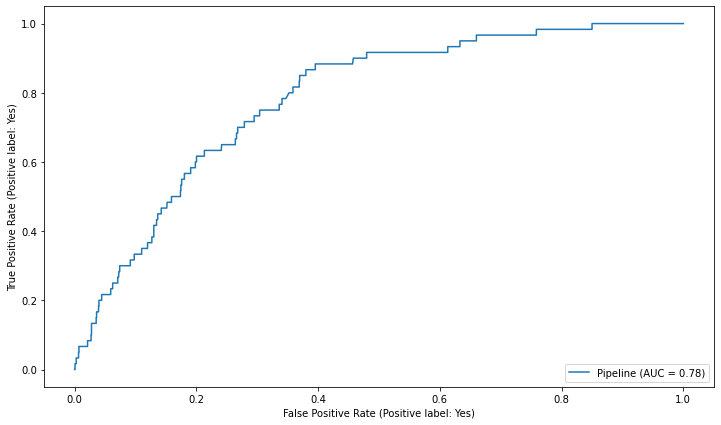

In [26]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

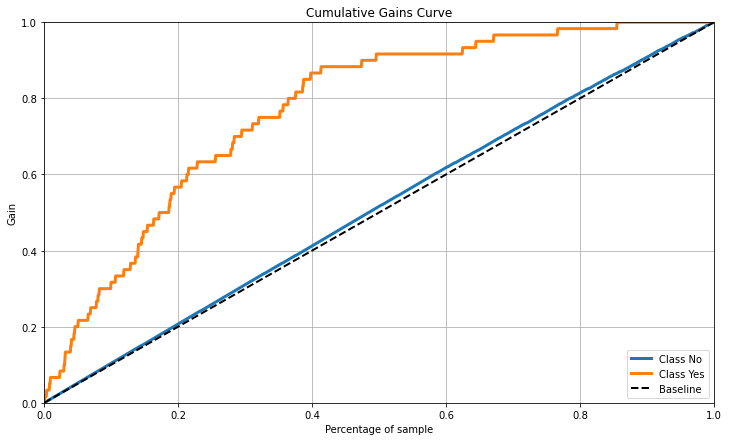

In [28]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test, y_probas)

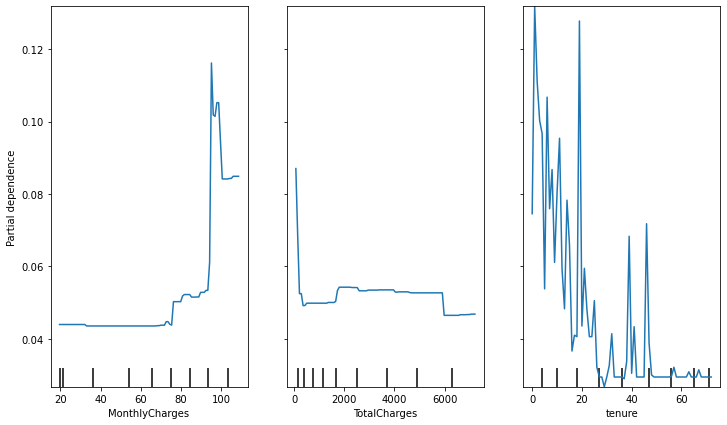

In [34]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(pipeline, X_train, numeric_features)

In [ ]:
x_Train = pipeline.named_steps['tfidv'].fit_transform(x_Train)
explainer = shap.KernelExplainer(pipeline.named_steps['lin_svc'].predict_proba, x_Train)